The following notebook creates tic tac toe players using a q-learning reinforcement learning strategy

In [0]:
import random
import matplotlib 
import numpy as np 
from collections import defaultdict 

In [0]:
class BoardEnvironment:
  """ this class creates an environment for agents to interact with"""

  def __init__(self):
    "initialize board"
  
  def set_players(self, playerA, playerB):
    " connects players with the environment "
    self.playerA = playerA
    self.playerB = playerB
    self.reset() # defines current_player
      
  def reset(self):
    self.turn = 'X' # the board always starts with X, regardless of which player

    # board states are a 9-character representing the state of the board.
    self.board = list('---------')  
    if (self.playerA and self.playerB): # if they are set
      self.playerA.reset_past()
      self.playerB.reset_past()
      if (random.random() < 0.5):  # randomly pick the player to start
        self.current_player = self.playerA
      else:
        self.current_player = self.playerB 

  def print_board(self, board_string = None):
    "print more readable board either from supplied board string or the current board"
    if not board_string:
      B = self.board
    else:
      B = board_string
    print(B[0],'|', B[1],'|', B[2], sep='')
    print('-----')
    print(B[3],'|', B[4],'|', B[5], sep='')
    print('-----')
    print(B[6],'|', B[7],'|', B[8], sep='')

  def get_state(self):
    return "".join(self.board)
  
  def other_player(self):
    # note, returns other player even if playerA is playing itself
    if (self.current_player == self.playerA):
      return self.playerB 
    else:
      return self.playerA  
    
  def available_actions(self):
    return [ind for ind, val in enumerate(self.board) if val == '-']

  def play_game(self): 
    # returns the winning player or None if a tie
    self.reset()
    while (not self.is_full() ):
      choice = self.current_player.select_action()

      self.board[choice] = self.turn # should check if valid

      if self.winner(self.turn):
        self.current_player.reward(100)
        self.other_player().reward(-100)
        return self.current_player
      else: # no one has won yet
        self.other_player().reward(0)

      # switch players
      self.turn = 'X' if self.turn == 'O' else 'O' # switch turn
      self.current_player = self.other_player()
    # it's a tie  
    return None
        
  def winner(self, check_for = ['X','O']):
    straight_lines = ((0,1,2),(3,4,5),(6,7,8),(0,3,6),
                      (1,4,7),(2,5,8),(0,4,8),(2,4,6))
    for turn in check_for:
        for line in straight_lines:
            if all(x == turn for x in (self.board[i] for i in line)):
                return turn
    return '' # if there is no winner

  def is_full(self):
    return('-' not in self.board) 

In [0]:
class Agent:
    """ this class is a generic Q-Learning reinforcement learning agent for discrete states and fixed actions
    represented as strings"""
    def __init__(self, environment, policy = 'max', learning_rate = 0.5, discount_factor = 0.95, epsilon = 0.01):
        if policy in ['max', 'random', 'epsilon']:
          self.policy = policy
        else:
          raise InputError(policy, ' is not an available policy')
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.Q = defaultdict(lambda: 0.0) # stores (state, action) value tuples as keys
        self.environment = environment
        self.epsilon = epsilon # Fraction of time making a random choice for epsilon policy
        self.reset_past()

    def reset_past(self):
      self.past_action = None
      self.past_state = None
          
    def select_action(self):
      available_actions = self.environment.available_actions()
      if (self.policy == 'random') or (self.policy == 'epsilon' and random.random() < self.epsilon):
        choice = random.choice(available_actions)
      else: #self.policy == 'max' or it's an epsilon policy determined to pick the max
        Q_vals = [self.Q[(self.environment.get_state(), x)] for x in available_actions]
        #randomly pick one of the maximum values
        max_val = max(Q_vals) # will often be 0 in the beginning
        max_pos = [i for i, j in enumerate(Q_vals) if j == max_val]
        max_indices = [available_actions[x] for x in max_pos]
        choice = random.choice(max_indices)
      self.past_state = self.environment.get_state()
      self.past_action = choice
      return choice
        
    def reward(self, reward_value):
        # finding the best expected reward
        available_actions = self.environment.available_actions()
        next_Q_vals = [self.Q[(self.environment.get_state(), x)] for x in available_actions]
        max_next_Q = max(next_Q_vals) if next_Q_vals else 0 # will often be 0 in the beginning
        td_target = reward_value + self.discount_factor * max_next_Q
        reward_pred_error = td_target - self.Q[(self.past_state,self.past_action)]
        #if (self.past_state or self.past_action):
        self.Q[(self.past_state,self.past_action)] += self.learning_rate * reward_pred_error

In [0]:
class RepeatedGames:
    def __init__(self, environment, playerA, playerB):
        self.environment = environment
        self.playerA = playerA
        self.playerB = playerB
        self.reset_history()
    
    def reset_history(self):
        self.history = []
    
    def play_game(self):
        self.environment.reset()
        winner = self.environment.play_game()
        if (winner == self.playerA):
          self.history.append('A')
        elif (winner == self.playerB):
          self.history.append('B')
        else:
          self.history.append('-')
    
    def play_games(self, games_to_play):
        for i in range(games_to_play):
            self.play_game()
        print(self.history[-games_to_play:].count('A'),'games won by player A')
        print(self.history[-games_to_play:].count('B'),'games won by player B')
        print(self.history[-games_to_play:].count('-'),'ties')

In [5]:
board = BoardEnvironment()
A = Agent(board, 'max')
B = Agent(board, 'random')
board.set_players(A,B)

tournament = RepeatedGames(board,A,B)
tournament.play_games(100)
print()
tournament.play_games(10000)
print()
tournament.play_games(100)

41 games won by player A
41 games won by player B
18 ties

7993 games won by player A
1215 games won by player B
792 ties

87 games won by player A
6 games won by player B
7 ties


In [6]:
# observe the highest and lowest board state action value functions
key_max = max(A.Q.keys(), key=(lambda k: A.Q[k]))
print("highest Q for player A:", A.Q[key_max],', state_action:', key_max)
board.print_board(key_max[0])
key_max = max(B.Q.keys(), key=(lambda k: B.Q[k]))
print("\nhighest Q for player B:", B.Q[key_max],', state_action:', key_max)
board.print_board(key_max[0])
key_min = min(A.Q.keys(), key=(lambda k: A.Q[k]))
print("\nlowest Q for player A:", A.Q[key_min],', state_action:', key_min)
board.print_board(key_min[0])
key_min = min(B.Q.keys(), key=(lambda k: B.Q[k]))
print("\nlowest Q for player B:", B.Q[key_min],', state_action:', key_min)
board.print_board(key_min[0])

highest Q for player A: 100.0 , state_action: ('-OX-X--O-', 6)
-|O|X
-----
-|X|-
-----
-|O|-

highest Q for player B: 99.90234375 , state_action: ('XOXOXO-XO', 6)
X|O|X
-----
O|X|O
-----
-|X|O

lowest Q for player A: -93.75 , state_action: ('O-XXXO-XO', 1)
O|-|X
-----
X|X|O
-----
-|X|O

lowest Q for player B: -100.0 , state_action: ('-OX-X----', 0)
-|O|X
-----
-|X|-
-----
-|-|-


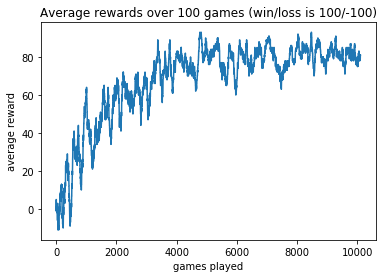

In [7]:
# plot the history
import numpy as np
import pylab as py
import matplotlib
%matplotlib inline 

history = np.array(tournament.history.copy())
rewards = np.zeros(len(history))
rewards[history == 'A'] = 100
rewards[history == 'B'] = -100

def running_mean(x, N):
    return np.convolve(x, np.ones((N,))/N, mode='valid')
r_mean = running_mean(rewards, 100)
py.plot(r_mean)
py.xlabel('games played')
py.ylabel('average reward')
py.title('Average rewards over 100 games (win/loss is 100/-100)');